## Setup environment

In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    RandScaleIntensityd,
    Compose,
    CropForegroundd,
    LoadImaged,
    RandShiftIntensityd,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    RandAffined,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    Resized,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet, BasicUNet
from monai.networks.layers import Norm
from torch.optim.lr_scheduler import CosineAnnealingLR

from monai.metrics import DiceMetric, ROCAUCMetric, MSEMetric
from monai.networks.utils import copy_model_state
from monai.optimizers import generate_param_groups
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np
import wandb
import copy
import nibabel as nib
%matplotlib inline

/home/adwaykanhere/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.backends.cudnn.benchmark = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



## Setup imports

In [4]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


print_config()

MONAI version: 1.2.dev2307
Numpy version: 1.23.1
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 06a031872bb3b001f4b3d78dd0f76913a2be8448
MONAI __file__: /home/adwaykanhere/anaconda3/envs/pytorch/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.0.1
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 4.6.3
TorchVision version: 0.14.1+cu117
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = '/home/adwaykanhere/Documents/SegViz/'
print(root_dir)

/home/adwaykanhere/Documents/SegViz/


## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [6]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir_spleen = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir_spleen):
    download_and_extract(resource, compressed_file, root_dir, md5)

In [7]:
resource_liver = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task03_Liver.tar"
md5_liver = "a90ec6c4aa7f6a3d087205e23d4e6397"

compressed_file_liver = os.path.join(root_dir, "Task03_Liver.tar")
data_dir_liver = os.path.join(root_dir, "Task03_Liver")
if not os.path.exists(data_dir_liver):
    download_and_extract(resource_liver, compressed_file_liver, root_dir, md5_liver)

In [8]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task07_Pancreas.tar"
md5_pan = "4f7080cfca169fa8066d17ce6eb061e4"

compressed_file_pan = os.path.join(root_dir, "Task07_Pancreas.tar")
data_dir_pan = os.path.join(root_dir, "Task07_Pancreas")
if not os.path.exists(data_dir_pan):
    download_and_extract(resource, compressed_file_pan, root_dir, md5_pan)

## Set MSD Spleen dataset path

In [9]:
train_images = sorted(
    glob.glob(os.path.join(data_dir_spleen, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir_spleen, "labelsTr", "*.nii.gz")))
data_dicts_spleen = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files_spleen, val_files_spleen = data_dicts_spleen[:-9], data_dicts_spleen[-9:]

## Set MSD Liver dataset path

In [10]:
train_images = sorted(
    glob.glob(os.path.join(data_dir_liver, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir_liver, "labelsTr", "*.nii.gz")))
data_dicts_liver = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files_liver, val_files_liver = data_dicts_liver[:-25], data_dicts_liver[-25:]

# Set MSD Pancreas dataset path

In [11]:
train_images = sorted(
    glob.glob(os.path.join(data_dir_pan, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir_pan, "labelsTr", "*.nii.gz")))
data_dicts_pan = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files_pan, val_files_pan = data_dicts_pan[:-56], data_dicts_pan[-56:]

# Set Kits dataset path

In [12]:
data_dir_kits = '/home/adwaykanhere/Documents/SegViz/Task040_KiTS'
train_images = sorted(
    glob.glob(os.path.join(data_dir_kits, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir_kits, "labelsTr", "*.nii.gz")))
data_dicts_kits = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files_kits, val_files_kits = data_dicts_kits[:-42], data_dicts_kits[-42:]

## Convert Multilabel to single label for liver and pancreas

In [13]:
# import nibabel as nib
# for image_path in sorted(glob.glob(os.path.join(data_dir_liver, "labelsTr", "*.nii.gz"))):
#     image_file = nib.load(image_path)
#     image_file_array = nib.load(image_path).get_fdata()
#     image_file_array[image_file_array > 1 ] = 1
#     image_file_final = nib.Nifti1Image(image_file_array, image_file.affine)
#     nib.save(image_file_final , image_path)

# for image_path in sorted(glob.glob(os.path.join(data_dir_pan, "labelsTr", "*.nii.gz"))):
#     image_file = nib.load(image_path)
#     image_file_array = nib.load(image_path).get_fdata()
#     image_file_array[image_file_array > 1 ] = 1
#     image_file_final = nib.Nifti1Image(image_file_array, image_file.affine)
#     nib.save(image_file_final , image_path)

# for image_path in sorted(glob.glob(os.path.join(data_dir_kits, "labelsTr", "*.nii.gz"))):
#     image_file = nib.load(image_path)
#     image_file_array = nib.load(image_path).get_fdata()
#     image_file_array[image_file_array > 1 ] = 1
#     image_file_final = nib.Nifti1Image(image_file_array, image_file.affine)
#     nib.save(image_file_final , image_path)

## Set deterministic training for reproducibility

In [14]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [15]:
train_transforms_spleen = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        Resized(keys=["image"], spatial_size=(256,256,128)),   
        Resized(keys=["label"], spatial_size=(256,256,128), mode='nearest'),   
        # CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(128,128,32),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        # user can also add other random transforms
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=1.0, spatial_size=(128,128,32),
            rotate_range=(0, 0, np.pi/15),
            scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transform_spleen = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

train_transforms_liver = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-200, a_max=200,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        Resized(keys=["image"], spatial_size=(256,256,128)),   
        Resized(keys=["label"], spatial_size=(256,256,128), mode='nearest'),   
        # CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(128,128,32),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        # user can also add other random transforms
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=1.0, spatial_size=(128,128,32),
            rotate_range=(0, 0, np.pi/15),
            scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transform_liver = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-200, a_max=200,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

train_transforms_pan = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-87, a_max=199,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        Resized(keys=["image"], spatial_size=(256,256,128)),   
        Resized(keys=["label"], spatial_size=(256,256,128), mode='nearest'),   
        # CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(128,128,32),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        # user can also add other random transforms
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=1.0, spatial_size=(128,128,32),
            rotate_range=(0, 0, np.pi/15),
            scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transform_pan = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-87, a_max=199,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

train_transforms_kits = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-79, a_max=304,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        Resized(keys=["image"], spatial_size=(256,256,128)),   
        Resized(keys=["label"], spatial_size=(256,256,128), mode='nearest'),   
        # CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(128,128,32),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        # user can also add other random transforms
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=1.0, spatial_size=(128,128,32),
            rotate_range=(0, 0, np.pi/15),
            scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transform_kits = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-79, a_max=304,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)


/home/adwaykanhere/anaconda3/envs/pytorch/lib/python3.9/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


## Check transforms in DataLoader

image shape: torch.Size([128, 128, 32]), label shape: torch.Size([128, 128, 32])
[0.]


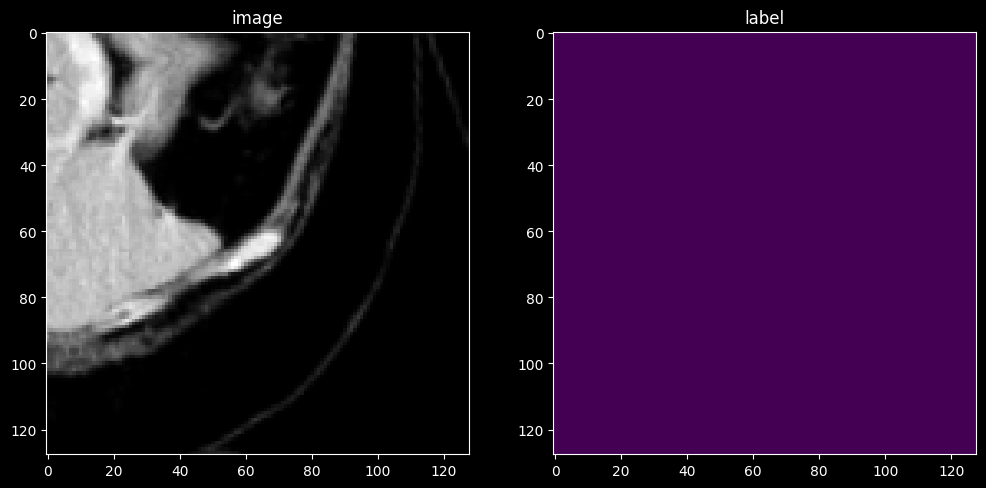

In [16]:
check_ds = Dataset(data=train_files_spleen, transform=train_transforms_spleen)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
print(np.unique(label))

# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 16], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 16])
plt.show()

image shape: torch.Size([128, 128, 32]), label shape: torch.Size([128, 128, 32])
[0. 1.]


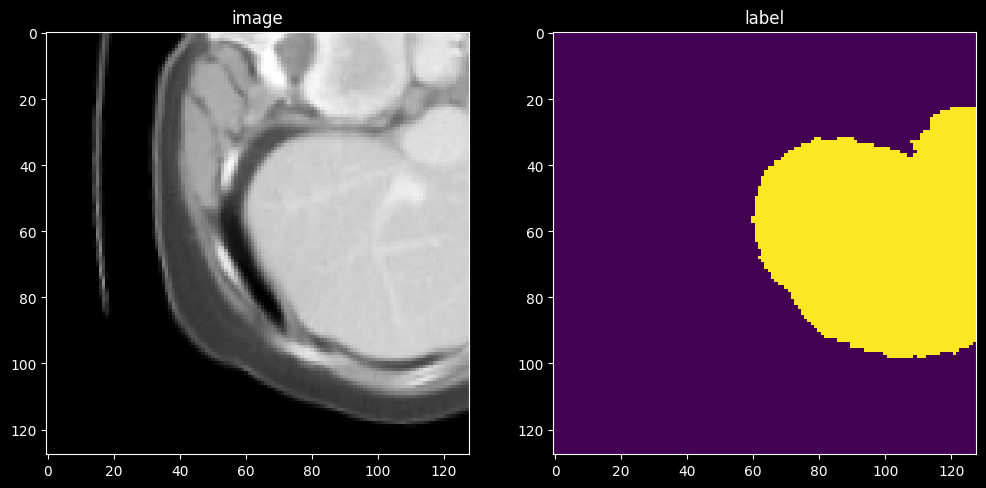

In [17]:
check_ds = Dataset(data=train_files_liver, transform=train_transforms_liver)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
print(np.unique(label))

# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 16], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 16])
plt.show()

image shape: torch.Size([128, 128, 32]), label shape: torch.Size([128, 128, 32])
[0. 1.]


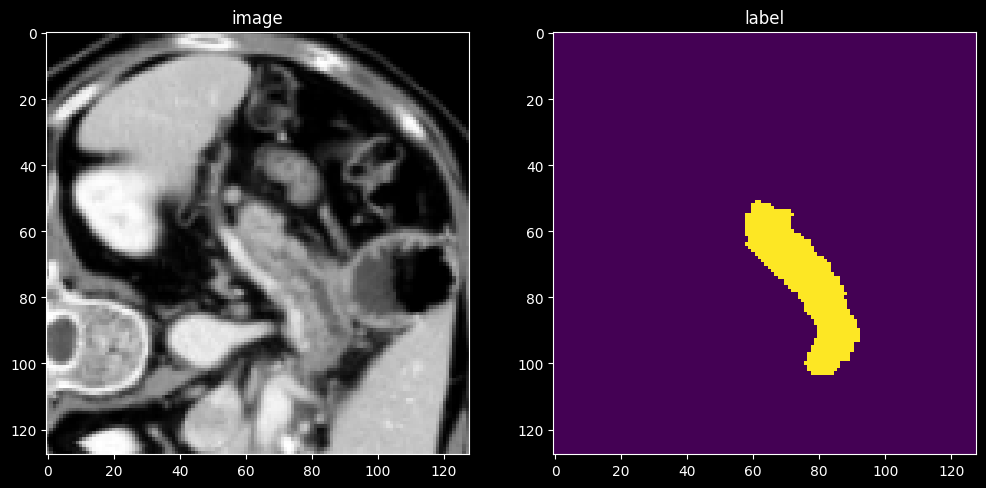

In [18]:
check_ds = Dataset(data=train_files_pan, transform=train_transforms_pan)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
print(np.unique(label))

# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 16], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 16])
plt.show()

image shape: torch.Size([128, 128, 32]), label shape: torch.Size([128, 128, 32])
[0. 1.]


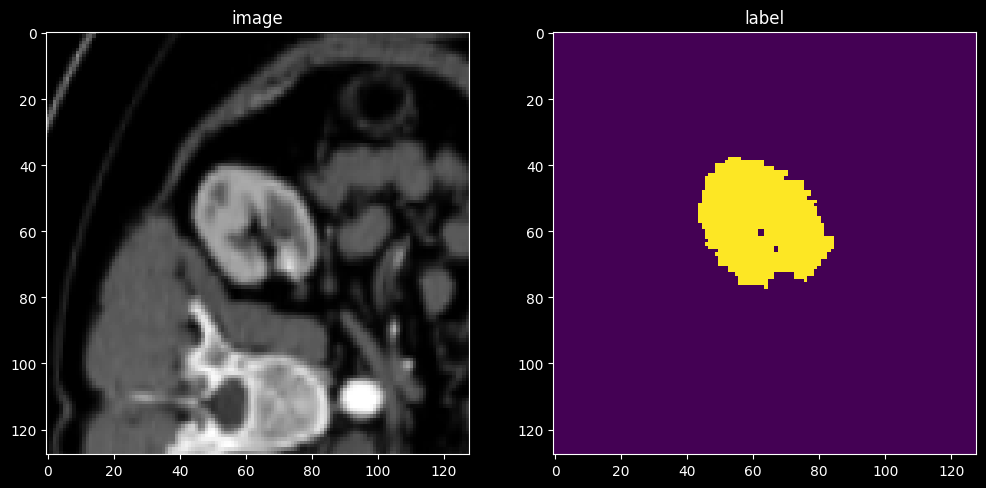

In [19]:
check_ds = Dataset(data=train_files_kits, transform=train_transforms_kits)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
print(np.unique(label))

# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 16], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 16])
plt.show()

In [20]:
config = {
    # data
    "cache_rate_spleen": 1.0,
    "num_workers": 0,


    # train settings
    "train_batch_size": 2,
    "val_batch_size": 1,
    "learning_rate": 1e-4,
    "max_epochs": 150,
    "val_interval": 2, # check validation score after n epochs
    "lr_scheduler": "cosine_decay", # just to keep track




    # Unet model (you can even use nested dictionary and this will be handled by W&B automatically)
    "model_type_spleen": "unet", # just to keep track
    "model_type_liver": "unet",
    "model_type_pan": "unet",
    "model_type_kits": "unet",
    "model_params_spleen": dict(spatial_dims=3,
                  in_channels=1,
                  out_channels=2,
                  channels=(16, 32, 64, 128, 256),
                  strides=(2, 2, 2, 2),
                  num_res_units=2,
                  norm=Norm.BATCH,),
    "model_params_liver": dict(spatial_dims=3,
                      in_channels=1,
                      out_channels=2,
                      channels=(16, 32, 64, 128, 256),
                      strides=(2, 2, 2, 2),
                      num_res_units=2,
                      norm=Norm.BATCH,),
    "model_params_pan": dict(spatial_dims=3,
                in_channels=1,
                out_channels=2,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2,
                norm=Norm.BATCH,),
    "model_params_kits": dict(spatial_dims=3,
                in_channels=1,
                out_channels=2,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2,
                norm=Norm.BATCH,),
    # data
    "cache_rate_liver": 0.4,
    "cache_rate_pan": 0.4,
    "cache_rate_kits": 0.4,
}

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [21]:
train_ds_spleen = CacheDataset(
    data=train_files_spleen, transform=train_transforms_spleen,
    cache_rate=config['cache_rate_spleen'], num_workers=config['num_workers'])
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader_spleen = DataLoader(train_ds_spleen, batch_size=config['train_batch_size'], shuffle=True, num_workers=config['num_workers'])

val_ds_spleen = CacheDataset(
    data=val_files_spleen, transform=val_transform_spleen, cache_rate=config['cache_rate_spleen'], num_workers=config['num_workers'])
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader_spleen = DataLoader(val_ds_spleen, batch_size=config['val_batch_size'], num_workers=config['num_workers'])

Loading dataset: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


In [22]:
train_ds_liver = CacheDataset(
    data=train_files_liver, transform=train_transforms_liver,
    cache_rate=config['cache_rate_liver'], num_workers=config['num_workers'])
# train_ds_liver = Dataset(data=train_files_liver, transform=train_transforms_liver)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader_liver = DataLoader(train_ds_liver, batch_size=config['train_batch_size'], shuffle=True, num_workers=config['num_workers'])

val_ds_liver = CacheDataset(
    data=val_files_liver, transform=val_transform_liver, cache_rate=config['cache_rate_liver'], num_workers=config['num_workers'])
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader_liver = DataLoader(val_ds_liver, batch_size=config['val_batch_size'], num_workers=config['num_workers'])

Loading dataset: 100%|██████████| 10/10 [00:54<00:00,  5.43s/it]


In [23]:
train_ds_pan = CacheDataset(
    data=train_files_pan, transform=train_transforms_pan,
    cache_rate=config['cache_rate_pan'], num_workers=config['num_workers'])
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader_pan = DataLoader(train_ds_pan, batch_size=config['train_batch_size'], shuffle=True, num_workers=config['num_workers'])

val_ds_pan = CacheDataset(
    data=val_files_pan, transform=val_transform_pan, cache_rate=config['cache_rate_pan'], num_workers=config['num_workers'])
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader_pan = DataLoader(val_ds_pan, batch_size=config['val_batch_size'], num_workers=config['num_workers'])

Loading dataset: 100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


In [24]:
train_ds_kits = CacheDataset(
    data=train_files_kits, transform=train_transforms_kits,
    cache_rate=config['cache_rate_kits'], num_workers=config['num_workers'])
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader_kits = DataLoader(train_ds_kits, batch_size=config['train_batch_size'], shuffle=True, num_workers=config['num_workers'])

val_ds_kits = CacheDataset(
    data=val_files_kits, transform=val_transform_kits, cache_rate=config['cache_rate_kits'], num_workers=config['num_workers'])
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader_kits = DataLoader(val_ds_kits, batch_size=config['val_batch_size'], num_workers=config['num_workers'])

Loading dataset: 100%|██████████| 16/16 [00:28<00:00,  1.79s/it]


## Create Model, Loss, Optimizer

In [25]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
model_spleen = UNet(**config['model_params_spleen']).to(device)
model_liver = UNet(**config['model_params_liver']).to(device)
model_pan = UNet(**config['model_params_pan']).to(device)
model_kits = UNet(**config['model_params_kits']).to(device)


loss_function_spleen = DiceLoss(to_onehot_y=True, softmax=True)
loss_function_liver = DiceLoss(to_onehot_y=True, softmax=True)
loss_function_pan = DiceLoss(to_onehot_y=True, softmax=True)
loss_function_kits = DiceLoss(to_onehot_y=True, softmax=True)

optimizer_spleen = torch.optim.Adam(model_spleen.parameters(), lr=config['learning_rate'])
optimizer_liver = torch.optim.Adam(model_liver.parameters(), lr=config['learning_rate'])
optimizer_pan = torch.optim.Adam(model_pan.parameters(), lr=config['learning_rate'])
optimizer_kits = torch.optim.Adam(model_kits.parameters(), lr=config['learning_rate'])

dice_metric_spleen = DiceMetric(include_background=False, reduction="mean")
dice_metric_liver = DiceMetric(include_background=False, reduction="mean")
dice_metric_pan = DiceMetric(include_background=False, reduction="mean")
dice_metric_kits = DiceMetric(include_background=False, reduction="mean")

scheduler_spleen = CosineAnnealingLR(optimizer_spleen, T_max=config['max_epochs'], eta_min=1e-9)
scheduler_liver = CosineAnnealingLR(optimizer_liver, T_max=config['max_epochs'], eta_min=1e-9)
scheduler_pan = CosineAnnealingLR(optimizer_pan, T_max=config['max_epochs'], eta_min=1e-9)
scheduler_kits = CosineAnnealingLR(optimizer_kits, T_max=config['max_epochs'], eta_min=1e-9)

In [ ]:
# 🐝 initialize a wandb run
wandb.init(
    project="SegViz_LSPK",
    config=config
)

## Execute a typical PyTorch training process

In [ ]:
# 🐝 log gradients of the model to wandb
wandb.watch(model_spleen, log_freq=100)
wandb.watch(model_liver, log_freq=100)
wandb.watch(model_pan, log_freq=100)
wandb.watch(model_kits, log_freq=100)



# model_spleen.load_state_dict(torch.load('/content/best_metric_model_spleen_128.pth'))
# model_liver.load_state_dict(torch.load('/content/best_metric_model_liver_128.pth'))
# model_pan.load_state_dict(torch.load('/content/best_metric_model_pan_128.pth'))


max_epochs = 1000
val_interval = 2
best_metric = -1
best_metric_spleen = -1
best_metric_liver = -1
best_metric_pan = -1
best_metric_kits = -1

best_metric_epoch = -1
best_metric_epoch_spleen = -1
best_metric_epoch_liver = -1
best_metric_epoch_pan = -1
best_metric_epoch_kits = -1

epoch_loss_values = []
metric_values = []

epoch_loss_values_spleen = []
metric_values_spleen = []

epoch_loss_values_liver = []
metric_values_liver = []

epoch_loss_values_pan = []
metric_values_pan = []

epoch_loss_values_kits = []
metric_values_kits = []

post_pred_spleen = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label_spleen = Compose([AsDiscrete(to_onehot=2)])

post_pred_liver = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label_liver = Compose([AsDiscrete(to_onehot=2)])

post_pred_pan = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label_pan = Compose([AsDiscrete(to_onehot=2)])

post_pred_kits = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label_kits = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
  epoch_loss_spleen = 0
  epoch_loss_liver = 0
  epoch_loss_pan = 0
  epoch_loss_kits = 0

  step_0 = 0
  step_1 = 0
  
  # For one epoch
  
  print("-" * 10)
  print(f"epoch {epoch + 1}/{max_epochs}")
  
  model_spleen.train()
  model_liver.train()
  model_pan.train()
  model_kits.train()
  
  # One forward pass of the spleen data through the spleen UNet
  for batch_data_spleen in train_loader_spleen:
      step_0 += 1
      inputs_spleen, labels_spleen = (
          batch_data_spleen["image"].to(device),
          batch_data_spleen["label"].to(device),
      )
      optimizer_spleen.zero_grad()
      outputs_spleen = model_spleen(inputs_spleen)
      
      loss_spleen = loss_function_spleen(outputs_spleen, labels_spleen)
      loss_spleen.backward()
      
      optimizer_spleen.step()
      epoch_loss_spleen += loss_spleen.item()
      print(
          f"{step_0}/{len(train_ds_spleen) // train_loader_spleen.batch_size}, "
          f"train_loss: {loss_spleen.item():.4f}")
      wandb.log({"train/loss spleen": loss_spleen.item()})
  epoch_loss_spleen /= step_0
  epoch_loss_values_spleen.append(epoch_loss_spleen)
  print(f"epoch {epoch + 1} average loss spleen: {epoch_loss_spleen:.4f}")


  # One forward pass of the liver data through the liver UNet
  for batch_data_liver in train_loader_liver:
      step_1 += 1
      inputs_liver, labels_liver = (
          batch_data_liver["image"].to(device),
          batch_data_liver["label"].to(device),
      )
      optimizer_liver.zero_grad()
      outputs_liver = model_liver(inputs_liver)
      loss_liver = loss_function_liver(outputs_liver, labels_liver)
      loss_liver.backward()
      optimizer_liver.step()
      epoch_loss_liver += loss_liver.item()
      print(
          f"{step_1}/{len(train_ds_liver) // train_loader_liver.batch_size}, "
          f"train_loss: {loss_liver.item():.4f}")
      wandb.log({"train/loss liver": loss_liver.item()})
  epoch_loss_liver /= step_1
  epoch_loss_values_liver.append(epoch_loss_liver)
  print(f"epoch {epoch + 1} average loss liver: {epoch_loss_liver:.4f}")

   # One forward pass of the pancreas data through the Pancreas UNet
  for batch_data_pan in train_loader_pan:
      step_1 += 1
      inputs_pan, labels_pan = (
          batch_data_pan["image"].to(device),
          batch_data_pan["label"].to(device),
      )
      optimizer_pan.zero_grad()
      outputs_pan = model_pan(inputs_pan)
      loss_pan = loss_function_pan(outputs_pan, labels_pan)
      loss_pan.backward()
      optimizer_pan.step()
      epoch_loss_pan += loss_pan.item()
      print(
          f"{step_1}/{len(train_ds_pan) // train_loader_pan.batch_size}, "
          f"train_loss: {loss_pan.item():.4f}")
      wandb.log({"train/loss pancreas": loss_pan.item()})
  epoch_loss_pan /= step_1
  epoch_loss_values_pan.append(epoch_loss_pan)
  print(f"epoch {epoch + 1} average loss pancreas: {epoch_loss_pan:.4f}")

  # One forward pass of the kidneys data through the KITS UNet
  for batch_data_kits in train_loader_kits:
      step_1 += 1
      inputs_kits, labels_kits = (
          batch_data_kits["image"].to(device),
          batch_data_kits["label"].to(device),
      )
      optimizer_kits.zero_grad()
      outputs_kits = model_kits(inputs_kits)
      loss_kits = loss_function_kits(outputs_kits, labels_kits)
      loss_kits.backward()
      optimizer_kits.step()
      epoch_loss_kits += loss_kits.item()
      print(
          f"{step_1}/{len(train_ds_kits) // train_loader_kits.batch_size}, "
          f"train_loss: {loss_kits.item():.4f}")
      wandb.log({"train/loss kidneys": loss_kits.item()})
  epoch_loss_kits /= step_1
  epoch_loss_values_kits.append(epoch_loss_kits)
  print(f"epoch {epoch + 1} average loss kidneys: {epoch_loss_kits:.4f}")
  
  scheduler_spleen.step()
  scheduler_liver.step()
  scheduler_pan.step()
  scheduler_kits.step()

  wandb.log({"train/loss_epoch spleen": epoch_loss_spleen})
    # 🐝 log learning rate after each epoch to wandb
  wandb.log({"learning_rate spleen": scheduler_spleen.get_last_lr()[0]})

  wandb.log({"train/loss_epoch liver": epoch_loss_liver})
      # 🐝 log learning rate after each epoch to wandb
  wandb.log({"learning_rate liver": scheduler_liver.get_last_lr()[0]})

  wandb.log({"train/loss_epoch pan": epoch_loss_pan})
      # 🐝 log learning rate after each epoch to wandb
  wandb.log({"learning_rate pan": scheduler_pan.get_last_lr()[0]})

  wandb.log({"train/loss_epoch kidneys": epoch_loss_kits})
      # 🐝 log learning rate after each epoch to wandb
  wandb.log({"learning_rate kidneys": scheduler_kits.get_last_lr()[0]})

  # Store weights before aggregation strategy
  
  if epoch % 10 == 0:
    meta_model = []
    weights_liver = []
    weights_spleen = []
    weights_pan = []
    weights_kits = []
    # Aggregate weights
    for name, param in model_liver.named_parameters():
      if not "model.2" in name:
        weights_liver.append(param)

    for name, param in model_spleen.named_parameters():
      if not "model.2" in name:
        weights_spleen.append(param)

    for name, param in model_pan.named_parameters():
      if not "model.2" in name:
        weights_pan.append(param)
    
    for name, param in model_kits.named_parameters():
      if not "model.2" in name:
        weights_kits.append(param)

    for weight_spleen, weight_liver, weight_pan, weight_kit in zip(weights_spleen,weights_liver,weights_pan, weights_kits):
      meta_model.append((weight_spleen + weight_liver + weight_pan + weight_kit)/4)   # Change aggregation strategy

    for index_old, param_old in enumerate(model_spleen.parameters()):
      for index_new, param_new in enumerate(meta_model):
        param_old = param_new

    for index_old, param_old in enumerate(model_liver.parameters()):
      for index_new, param_new in enumerate(meta_model):
        param_old = param_new
    
    for index_old, param_old in enumerate(model_pan.parameters()):
      for index_new, param_new in enumerate(meta_model):
        param_old = param_new
    
    for index_old, param_old in enumerate(model_kits.parameters()):
      for index_new, param_new in enumerate(meta_model):
        param_old = param_new
    # model_spleen_copy = copy.deepcopy(model_spleen)
    # model_liver_copy = copy.deepcopy(model_liver)

    # pretrained_dict_spleen, updated_keys_spleen, unchanged_keys_spleen = copy_model_state(
    #   model_spleen, model_spleen_copy, exclude_vars="model.2.1")
   
    # pretrained_dict_liver, updated_keys_liver, unchanged_keys_liver = copy_model_state(
    #   model_liver, model_liver_copy, exclude_vars="model.2.1")
    
    # for param_tensor_spleen, param_tensor_liver in zip(pretrained_dict_spleen, pretrained_dict_liver):
    #   agg_tensor = ( pretrained_dict_spleen[param_tensor_spleen] + pretrained_dict_liver[param_tensor_liver] ) / 2
      
    #   pretrained_dict_spleen[param_tensor_spleen] = agg_tensor
    #   pretrained_dict_liver[param_tensor_liver] = agg_tensor


    # model_spleen.load_state_dict(pretrained_dict_spleen)
    # model_liver.load_state_dict(pretrained_dict_liver)

  # Validation 
  if (epoch + 1) % val_interval == 0:
    model_spleen.eval()
    model_liver.eval()
    model_pan.eval()
    model_kits.eval()

    with torch.no_grad():

        # Validation forward spleen
        for val_data_spleen in val_loader_spleen:
            val_inputs_spleen, val_labels_spleen = (
                val_data_spleen["image"].to(device),
                val_data_spleen["label"].to(device),
            )
            roi_size = (160, 160, 160)
            sw_batch_size = 4
            val_outputs_spleen = sliding_window_inference(
                val_inputs_spleen, roi_size, sw_batch_size, model_spleen)
            val_outputs_spleen = [post_pred_spleen(i) for i in decollate_batch(val_outputs_spleen)]
            val_labels_spleen = [post_label_spleen(i) for i in decollate_batch(val_labels_spleen)]
            # compute metric for current iteration
            dice_metric_spleen(y_pred=val_outputs_spleen, y=val_labels_spleen)

        # aggregate the final mean dice result
        metric_spleen = dice_metric_spleen.aggregate().item()
        wandb.log({"val/dice_metric spleen": metric_spleen})
        scheduler_spleen.step(metric_spleen)
        # reset the status for next validation round
        dice_metric_spleen.reset()

        metric_values_spleen.append(metric_spleen)
        if metric_spleen > best_metric_spleen:
            best_metric_spleen = metric_spleen
            best_metric_epoch_spleen = epoch + 1
        #     torch.save(model_spleen.state_dict(), os.path.join(
        #         root_dir, "best_metric_model_spleen_128.pth"))
        #     print("saved new best metric model for spleen dataset")
            print(
                f"current epoch: {epoch + 1} current mean dice for spleen: {metric_spleen:.4f}"
                f"\nbest mean dice for spleen: {best_metric_spleen:.4f} "
                f"at epoch: {best_metric_epoch_spleen}"
            )


        # Validation forward Liver 
        for val_data_liver in val_loader_liver:
            val_inputs_liver, val_labels_liver = (
                val_data_liver["image"].to(device),
                val_data_liver["label"].to(device),
            )
            roi_size = (160, 160, 160)
            sw_batch_size = 4
            val_outputs_liver = sliding_window_inference(
                val_inputs_liver, roi_size, sw_batch_size, model_liver)
            val_outputs_liver = [post_pred_liver(i) for i in decollate_batch(val_outputs_liver)]
            val_labels_liver = [post_label_liver(i) for i in decollate_batch(val_labels_liver)]
            # compute metric for current iteration
            dice_metric_liver(y_pred=val_outputs_liver, y=val_labels_liver)

        # aggregate the final mean dice result
        metric_liver = dice_metric_liver.aggregate().item()
        wandb.log({"val/dice_metric liver": metric_liver})

        scheduler_liver.step(metric_liver)
        # reset the status for next validation round
        dice_metric_liver.reset()

        metric_values_liver.append(metric_liver)
        if metric_liver > best_metric_liver:
            best_metric_liver = metric_liver
            best_metric_epoch_liver = epoch + 1
        #     torch.save(model_liver.state_dict(), os.path.join(
        #         root_dir, "best_metric_model_liver_128.pth"))
        #     print("saved new best metric model for liver dataset")
            print(
                f"current epoch: {epoch + 1} current mean dice for liver: {metric_liver:.4f}"
                f"\nbest mean dice for liver: {best_metric_liver:.4f} "
                f"at epoch: {best_metric_epoch_liver}"
            )

        # Validation forward Pancreas
        for val_data_pan in val_loader_pan:
            val_inputs_pan, val_labels_pan = (
                val_data_pan["image"].to(device),
                val_data_pan["label"].to(device),
            )
            roi_size = (160, 160, 160)
            sw_batch_size = 4
            val_outputs_pan = sliding_window_inference(
                val_inputs_pan, roi_size, sw_batch_size, model_pan)
            val_outputs_pan = [post_pred_pan(i) for i in decollate_batch(val_outputs_pan)]
            val_labels_pan = [post_label_pan(i) for i in decollate_batch(val_labels_pan)]
            # compute metric for current iteration
            dice_metric_pan(y_pred=val_outputs_pan, y=val_labels_pan)

        # aggregate the final mean dice result
        metric_pan = dice_metric_pan.aggregate().item()
        wandb.log({"val/dice_metric Pancreas": metric_pan})

        scheduler_pan.step(metric_pan)
        # reset the status for next validation round
        dice_metric_pan.reset()
        metric_values_pan.append(metric_pan)
        if metric_pan > best_metric_pan:
            best_metric_pan = metric_pan
            best_metric_epoch_pan = epoch + 1
            print(
                f"current epoch: {epoch + 1} current mean dice for pancreas: {metric_pan:.4f}"
                f"\nbest mean dice for pancreas: {best_metric_pan:.4f} "
                f"at epoch: {best_metric_epoch_pan}"
            )


        # Validation forward KITS
        for val_data_kits in val_loader_kits:
            val_inputs_kits, val_labels_kits = (
                val_data_kits["image"].to(device),
                val_data_kits["label"].to(device),
            )
            roi_size = (160, 160, 160)
            sw_batch_size = 4
            val_outputs_kits = sliding_window_inference(
                val_inputs_kits, roi_size, sw_batch_size, model_kits)
            val_outputs_kits = [post_pred_kits(i) for i in decollate_batch(val_outputs_kits)]
            val_labels_kits = [post_label_kits(i) for i in decollate_batch(val_labels_kits)]
            # compute metric for current iteration
            dice_metric_kits(y_pred=val_outputs_kits, y=val_labels_kits)

        # aggregate the final mean dice result
        metric_kits = dice_metric_kits.aggregate().item()
        wandb.log({"val/dice_metric KITS": metric_kits})

        scheduler_kits.step(metric_kits)
        # reset the status for next validation round
        dice_metric_kits.reset()
        metric_values_kits.append(metric_kits)
        if metric_kits > best_metric_kits:
            best_metric_kits = metric_kits
            best_metric_epoch_kits = epoch + 1
            print(
                f"current epoch: {epoch + 1} current mean dice for kidneys: {metric_kits:.4f}"
                f"\nbest mean dice for kidneys: {best_metric_kits:.4f} "
                f"at epoch: {best_metric_epoch_kits}"
            )

        avg_metric = (metric_pan + metric_spleen + metric_liver + metric_kits) / 4

        metric_values.append(avg_metric)

        if avg_metric > best_metric:
            best_metric = avg_metric
            best_metric_epoch = epoch + 1
            torch.save(model_pan.state_dict(), os.path.join(
                root_dir, "best_metric_model_pan_128_segviz_LSPK.pth"))
            torch.save(model_liver.state_dict(), os.path.join(
                root_dir, "best_metric_model_liver_128_segviz_LSPK.pth"))
            torch.save(model_spleen.state_dict(), os.path.join(
                root_dir, "best_metric_model_spleen_128_segviz_LSPK.pth"))
            torch.save(model_kits.state_dict(), os.path.join(
                root_dir, "best_metric_model_kits_128_segviz_LSPK.pth"))
            print("saved new best metric model all datasets")
        


wandb.log({"best_dice_metric spleen": best_metric_spleen, "best_metric_epoch spleen": best_metric_epoch_spleen})
wandb.log({"best_dice_metric liver": best_metric_liver, "best_metric_epoch liver": best_metric_epoch_liver})
wandb.log({"best_dice_metric pancreas": best_metric_pan, "best_metric_epoch pancreas": best_metric_epoch_pan})
wandb.log({"best_dice_metric kidneys": best_metric_kits, "best_metric_epoch kidneys": best_metric_epoch_kits})


# best_model_path_spleen = os.path.join(root_dir, "best_metric_model_spleen_128.pth")
# model_artifact = wandb.Artifact(
#             "unet", type="model",
#             description="Segviz branch spleen",
#             metadata=dict(config['model_params_spleen']))
# model_artifact.add_file(best_model_path_spleen)
# wandb.log_artifact(model_artifact)

# best_model_path_liver = os.path.join(root_dir, "best_metric_model_liver_128.pth")
# model_artifact = wandb.Artifact(
#             "unet", type="model",
#             description="Segviz branch liver",
#             metadata=dict(config['model_params_liver']))
# model_artifact.add_file(best_model_path_liver)
# wandb.log_artifact(model_artifact)

# best_model_path_pan = os.path.join(root_dir, "best_metric_model_pan_128.pth")
# model_artifact = wandb.Artifact(:
#             "unet", type="model",
#             description="Segviz branch pancreas",
#             metadata=dict(config['model_params_pan']))
# model_artifact.add_file(best_model_path_pan)
# wandb.log_artifact(model_artifact)

In [ ]:
# print(
#     f"For Spleen:  train completed, best_metric: {best_metric_spleen:.4f} \n"
#     f"at epoch: {best_metric_epoch_spleen} \n"
#     f"For Liver:  train completed, best_metric: {best_metric_liver:.4f} \n"
#     f"at epoch: {best_metric_epoch_liver}"
#     f"For Pancreas:  train completed, best_metric: {best_metric_pan:.4f} \n"
#     f"at epoch: {best_metric_epoch_pan}"
#     f"For Kidneys:  train completed, best_metric: {best_metric_liver:.4f} \n"
#     f"at epoch: {best_metric_epoch_liver}")

# Finetuning 

In [26]:
model_spleen.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model_spleen_128_segviz_LSPK.pth")))

model_liver.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model_liver_128_segviz_LSPK.pth")))

model_pan.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model_pan_128_segviz_LSPK.pth")))

model_kits.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model_kits_128_segviz_LSPK.pth")))

<All keys matched successfully>

In [27]:
# Freeze model layers

params_to_train = ['model.2.0.conv.weight',
'model.2.0.conv.bias',
'model.2.0.adn.N.weight',
'model.2.0.adn.N.bias',
'model.2.0.adn.A.weight',
'model.2.1.conv.unit0.conv.weight',
'model.2.1.conv.unit0.conv.bias']

for name, param in model_spleen.named_parameters():
    param.requires_grad = True if name in params_to_train else False


for name, param in model_liver.named_parameters():
    param.requires_grad = True if name in params_to_train else False


for name, param in model_pan.named_parameters():
    param.requires_grad = True if name in params_to_train else False

for name, param in model_kits.named_parameters():
    param.requires_grad = True if name in params_to_train else False

In [28]:
# # 🐝 initialize a wandb run
# wandb.init(
#     project="SegViz_LSP",
#     config=config
# )

# # 🐝 log gradients of the model to wandb
# wandb.watch(model_spleen, log_freq=100)
# wandb.watch(model_liver, log_freq=100)
# wandb.watch(model_pan, log_freq=100)


# model_spleen.load_state_dict(torch.load('/content/best_metric_model_spleen_128.pth'))
# model_liver.load_state_dict(torch.load('/content/best_metric_model_liver_128.pth'))
# model_pan.load_state_dict(torch.load('/content/best_metric_model_pan_128.pth'))


max_epochs = 150
val_interval = 2
best_metric = -1
best_metric_spleen = -1
best_metric_liver = -1
best_metric_pan = -1
best_metric_kits = -1

best_metric_epoch = -1
best_metric_epoch_spleen = -1
best_metric_epoch_liver = -1
best_metric_epoch_pan = -1
best_metric_epoch_kits = -1

epoch_loss_values = []
metric_values = []

epoch_loss_values_spleen = []
metric_values_spleen = []

epoch_loss_values_liver = []
metric_values_liver = []

epoch_loss_values_pan = []
metric_values_pan = []

epoch_loss_values_kits = []
metric_values_kits = []

post_pred_spleen = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label_spleen = Compose([AsDiscrete(to_onehot=2)])

post_pred_liver = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label_liver = Compose([AsDiscrete(to_onehot=2)])

post_pred_pan = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label_pan = Compose([AsDiscrete(to_onehot=2)])

post_pred_kits = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label_kits = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
  epoch_loss_spleen = 0
  epoch_loss_liver = 0
  epoch_loss_pan = 0
  epoch_loss_kits = 0

  step_0 = 0
  step_1 = 0
  
  # For one epoch
  
  print("-" * 10)
  print(f"epoch {epoch + 1}/{max_epochs}")
  
  model_spleen.train()
  model_liver.train()
  model_pan.train()
  model_kits.train()
  
  # One forward pass of the spleen data through the spleen UNet
  for batch_data_spleen in train_loader_spleen:
      step_0 += 1
      inputs_spleen, labels_spleen = (
          batch_data_spleen["image"].to(device),
          batch_data_spleen["label"].to(device),
      )
      optimizer_spleen.zero_grad()
      outputs_spleen = model_spleen(inputs_spleen)
      
      loss_spleen = loss_function_spleen(outputs_spleen, labels_spleen)
      loss_spleen.backward()
      
      optimizer_spleen.step()
      epoch_loss_spleen += loss_spleen.item()
      print(
          f"{step_0}/{len(train_ds_spleen) // train_loader_spleen.batch_size}, "
          f"train_loss: {loss_spleen.item():.4f}")
    #   wandb.log({"train/loss spleen": loss_spleen.item()})
  epoch_loss_spleen /= step_0
  epoch_loss_values_spleen.append(epoch_loss_spleen)
  print(f"epoch {epoch + 1} average loss spleen: {epoch_loss_spleen:.4f}")


  # One forward pass of the liver data through the liver UNet
  for batch_data_liver in train_loader_liver:
      step_1 += 1
      inputs_liver, labels_liver = (
          batch_data_liver["image"].to(device),
          batch_data_liver["label"].to(device),
      )
      optimizer_liver.zero_grad()
      outputs_liver = model_liver(inputs_liver)
      loss_liver = loss_function_liver(outputs_liver, labels_liver)
      loss_liver.backward()
      optimizer_liver.step()
      epoch_loss_liver += loss_liver.item()
      print(
          f"{step_1}/{len(train_ds_liver) // train_loader_liver.batch_size}, "
          f"train_loss: {loss_liver.item():.4f}")
    #   wandb.log({"train/loss liver": loss_liver.item()})
  epoch_loss_liver /= step_1
  epoch_loss_values_liver.append(epoch_loss_liver)
  print(f"epoch {epoch + 1} average loss liver: {epoch_loss_liver:.4f}")

   # One forward pass of the liver data through the Pancreas UNet
  for batch_data_pan in train_loader_pan:
      step_1 += 1
      inputs_pan, labels_pan = (
          batch_data_pan["image"].to(device),
          batch_data_pan["label"].to(device),
      )
      optimizer_pan.zero_grad()
      outputs_pan = model_pan(inputs_pan)
      loss_pan = loss_function_pan(outputs_pan, labels_pan)
      loss_pan.backward()
      optimizer_pan.step()
      epoch_loss_pan += loss_pan.item()
      print(
          f"{step_1}/{len(train_ds_pan) // train_loader_pan.batch_size}, "
          f"train_loss: {loss_pan.item():.4f}")
    #   wandb.log({"train/loss pancreas": loss_pan.item()})
  epoch_loss_pan /= step_1
  epoch_loss_values_pan.append(epoch_loss_pan)
  print(f"epoch {epoch + 1} average loss pancreas: {epoch_loss_pan:.4f}")
  
  for batch_data_kits in train_loader_kits:
      step_1 += 1
      inputs_kits, labels_kits = (
          batch_data_kits["image"].to(device),
          batch_data_kits["label"].to(device),
      )
      optimizer_kits.zero_grad()
      outputs_kits = model_kits(inputs_kits)
      loss_kits = loss_function_kits(outputs_kits, labels_kits)
      loss_kits.backward()
      optimizer_kits.step()
      epoch_loss_kits += loss_kits.item()
      print(
          f"{step_1}/{len(train_ds_kits) // train_loader_kits.batch_size}, "
          f"train_loss: {loss_kits.item():.4f}")
    #   wandb.log({"train/loss kidneys": loss_kits.item()})
  epoch_loss_kits /= step_1
  epoch_loss_values_kits.append(epoch_loss_kits)
  print(f"epoch {epoch + 1} average loss kidneys: {epoch_loss_kits:.4f}")

  scheduler_spleen.step()
  scheduler_liver.step()
  scheduler_pan.step()
  scheduler_kits.step()

#   wandb.log({"train/loss_epoch spleen": epoch_loss_spleen})
#     # 🐝 log learning rate after each epoch to wandb
#   wandb.log({"learning_rate spleen": scheduler_spleen.get_lr()[0]})

#   wandb.log({"train/loss_epoch liver": epoch_loss_liver})
#       # 🐝 log learning rate after each epoch to wandb
#   wandb.log({"learning_rate liver": scheduler_liver.get_lr()[0]})

#   wandb.log({"train/loss_epoch pan": epoch_loss_pan})
#       # 🐝 log learning rate after each epoch to wandb
#   wandb.log({"learning_rate pan": scheduler_pan.get_lr()[0]})

  # Store weights before aggregation strategy
  
#   if epoch % 10 == 0:
#     meta_model = []
#     weights_liver = []
#     weights_spleen = []
#     weights_pan = []
#     # Aggregate weights
#     for name, param in model_liver.named_parameters():
#       if not "model.2" in name:
#         weights_liver.append(param)

#     for name, param in model_spleen.named_parameters():
#       if not "model.2" in name:
#         weights_spleen.append(param)

#     for name, param in model_pan.named_parameters():
#       if not "model.2" in name:
#         weights_pan.append(param)

#     for weight_spleen, weight_liver, weight_pan in zip(weights_spleen,weights_liver,weights_pan):
#       meta_model.append((weight_spleen + weight_liver + weight_pan)/3)   # Change aggregation strategy

#     for index_old, param_old in enumerate(model_spleen.parameters()):
#       for index_new, param_new in enumerate(meta_model):
#         param_old = param_new

#     for index_old, param_old in enumerate(model_liver.parameters()):
#       for index_new, param_new in enumerate(meta_model):
#         param_old = param_new
    
#     for index_old, param_old in enumerate(model_pan.parameters()):
#       for index_new, param_new in enumerate(meta_model):
#         param_old = param_new

    # model_spleen_copy = copy.deepcopy(model_spleen)
    # model_liver_copy = copy.deepcopy(model_liver)

    # pretrained_dict_spleen, updated_keys_spleen, unchanged_keys_spleen = copy_model_state(
    #   model_spleen, model_spleen_copy, exclude_vars="model.2.1")
   
    # pretrained_dict_liver, updated_keys_liver, unchanged_keys_liver = copy_model_state(
    #   model_liver, model_liver_copy, exclude_vars="model.2.1")
    
    # for param_tensor_spleen, param_tensor_liver in zip(pretrained_dict_spleen, pretrained_dict_liver):
    #   agg_tensor = ( pretrained_dict_spleen[param_tensor_spleen] + pretrained_dict_liver[param_tensor_liver] ) / 2
      
    #   pretrained_dict_spleen[param_tensor_spleen] = agg_tensor
    #   pretrained_dict_liver[param_tensor_liver] = agg_tensor


    # model_spleen.load_state_dict(pretrained_dict_spleen)
    # model_liver.load_state_dict(pretrained_dict_liver)

  # Validation 
  if (epoch + 1) % val_interval == 0:
    model_spleen.eval()
    model_liver.eval()
    model_pan.eval()
    model_kits.eval()

    with torch.no_grad():

        # Validation forward spleen
        for val_data_spleen in val_loader_spleen:
            val_inputs_spleen, val_labels_spleen = (
                val_data_spleen["image"].to(device),
                val_data_spleen["label"].to(device),
            )
            roi_size = (160, 160, 160)
            sw_batch_size = 4
            val_outputs_spleen = sliding_window_inference(
                val_inputs_spleen, roi_size, sw_batch_size, model_spleen)
            val_outputs_spleen = [post_pred_spleen(i) for i in decollate_batch(val_outputs_spleen)]
            val_labels_spleen = [post_label_spleen(i) for i in decollate_batch(val_labels_spleen)]
            # compute metric for current iteration
            dice_metric_spleen(y_pred=val_outputs_spleen, y=val_labels_spleen)

        # aggregate the final mean dice result
        metric_spleen = dice_metric_spleen.aggregate().item()
        # wandb.log({"val/dice_metric spleen": metric_spleen})
        scheduler_spleen.step(metric_spleen)
        # reset the status for next validation round
        dice_metric_spleen.reset()

        metric_values_spleen.append(metric_spleen)
        if metric_spleen > best_metric_spleen:
            best_metric_spleen = metric_spleen
            best_metric_epoch_spleen = epoch + 1
            torch.save(model_spleen.state_dict(), os.path.join(
                root_dir, "best_metric_model_spleen_128segviz_finetuned_LSPK.pth"))
            print("saved new best metric model for spleen dataset")
        print(
            f"current epoch: {epoch + 1} current mean dice for spleen: {metric_spleen:.4f}"
            f"\nbest mean dice for spleen: {best_metric_spleen:.4f} "
            f"at epoch: {best_metric_epoch_spleen}"
        )


        # Validation forward Liver 
        for val_data_liver in val_loader_liver:
            val_inputs_liver, val_labels_liver = (
                val_data_liver["image"].to(device),
                val_data_liver["label"].to(device),
            )
            roi_size = (160, 160, 160)
            sw_batch_size = 4
            val_outputs_liver = sliding_window_inference(
                val_inputs_liver, roi_size, sw_batch_size, model_liver)
            val_outputs_liver = [post_pred_liver(i) for i in decollate_batch(val_outputs_liver)]
            val_labels_liver = [post_label_liver(i) for i in decollate_batch(val_labels_liver)]
            # compute metric for current iteration
            dice_metric_liver(y_pred=val_outputs_liver, y=val_labels_liver)

        # aggregate the final mean dice result
        metric_liver = dice_metric_liver.aggregate().item()
        # wandb.log({"val/dice_metric liver": metric_liver})

        scheduler_liver.step(metric_liver)
        # reset the status for next validation round
        dice_metric_liver.reset()

        metric_values_liver.append(metric_liver)
        if metric_liver > best_metric_liver:
            best_metric_liver = metric_liver
            best_metric_epoch_liver = epoch + 1
            torch.save(model_liver.state_dict(), os.path.join(
                root_dir, "best_metric_model_liver_128segviz_finetuned_LSPK.pth"))
            print("saved new best metric model for liver dataset")
        print(
            f"current epoch: {epoch + 1} current mean dice for liver: {metric_liver:.4f}"
            f"\nbest mean dice for liver: {best_metric_liver:.4f} "
            f"at epoch: {best_metric_epoch_liver}"
        )


        # Validation forward KITS 
        for val_data_kits in val_loader_kits:
            val_inputs_kits, val_labels_kits = (
                val_data_kits["image"].to(device),
                val_data_kits["label"].to(device),
            )
            roi_size = (160, 160, 160)
            sw_batch_size = 4
            val_outputs_kits = sliding_window_inference(
                val_inputs_kits, roi_size, sw_batch_size, model_kits)
            val_outputs_kits = [post_pred_kits(i) for i in decollate_batch(val_outputs_kits)]
            val_labels_kits = [post_label_kits(i) for i in decollate_batch(val_labels_kits)]
            # compute metric for current iteration
            dice_metric_kits(y_pred=val_outputs_kits, y=val_labels_kits)

        # aggregate the final mean dice result
        metric_kits = dice_metric_kits.aggregate().item()
        # wandb.log({"val/dice_metric KITS": metric_kits})

        scheduler_kits.step(metric_kits)
        # reset the status for next validation round
        dice_metric_kits.reset()
        metric_values_kits.append(metric_kits)
        if metric_kits > best_metric_kits:
            best_metric_kits = metric_kits
            best_metric_epoch_kits = epoch + 1
            torch.save(model_kits.state_dict(), os.path.join(
                root_dir, "best_metric_model_kits_128segviz_finetuned_LSPK.pth"))
            print("saved new best metric model for KITS dataset")
        print(
            f"current epoch: {epoch + 1} current mean dice for KITS: {metric_kits:.4f}"
            f"\nbest mean dice for KITS: {best_metric_kits:.4f} "
            f"at epoch: {best_metric_epoch_kits}"
        )


        # Validation forward Pancreas
        for val_data_pan in val_loader_pan:
            val_inputs_pan, val_labels_pan = (
                val_data_pan["image"].to(device),
                val_data_pan["label"].to(device),
            )
            roi_size = (160, 160, 160)
            sw_batch_size = 4
            val_outputs_pan = sliding_window_inference(
                val_inputs_pan, roi_size, sw_batch_size, model_pan)
            val_outputs_pan = [post_pred_pan(i) for i in decollate_batch(val_outputs_pan)]
            val_labels_pan = [post_label_pan(i) for i in decollate_batch(val_labels_pan)]
            # compute metric for current iteration
            dice_metric_pan(y_pred=val_outputs_pan, y=val_labels_pan)

        # aggregate the final mean dice result
        metric_pan = dice_metric_pan.aggregate().item()
        # wandb.log({"val/dice_metric Pancreas": metric_pan})

        scheduler_pan.step(metric_pan)
        # reset the status for next validation round
        dice_metric_pan.reset()

        avg_metric = (metric_pan + metric_spleen + metric_liver) / 3

        metric_values.append(avg_metric)
        if metric_pan > best_metric_pan:
            best_metric_pan = metric_pan
            best_metric_epoch_pan = epoch + 1
            torch.save(model_pan.state_dict(), os.path.join(
                root_dir, "best_metric_model_pan_128segviz_finetuned_LSPK.pth"))
            print("saved new best metric model for liver dataset")
        print(
            f"current epoch: {epoch + 1} current mean dice for pancreas: {metric_pan:.4f}"
            f"\nbest mean dice for pancreas: {best_metric_pan:.4f} "
            f"at epoch: {best_metric_epoch_pan}"
        )
        # if avg_metric > best_metric:
        #     best_metric = avg_metric
        #     best_metric_epoch = epoch + 1
        #     torch.save(model_pan.state_dict(), os.path.join(
        #         root_dir, "best_metric_model_pan_128_segviz.pth"))
        #     torch.save(model_liver.state_dict(), os.path.join(
        #         root_dir, "best_metric_model_liver_128_segviz.pth"))
        #     torch.save(model_spleen.state_dict(), os.path.join(
        #         root_dir, "best_metric_model_spleen_128_segviz.pth"))
        #     print("saved new best metric model all three dataset")
        # print(
        #     f"current epoch: {epoch + 1} current mean dice for pancreas: {metric_pan:.4f}"
        #     f"\nbest mean dice for pancreas: {best_metric_pan:.4f} "
        #     f"at epoch: {best_metric_epoch_pan}"
        # )


# wandb.log({"best_dice_metric spleen": best_metric_spleen, "best_metric_epoch spleen": best_metric_epoch_spleen})
# wandb.log({"best_dice_metric liver": best_metric_liver, "best_metric_epoch liver": best_metric_epoch_liver})
# wandb.log({"best_dice_metric pancreas": best_metric_pan, "best_metric_epoch pancreas": best_metric_epoch_pan})


# best_model_path_spleen = os.path.join(root_dir, "best_metric_model_spleen_128.pth")
# model_artifact = wandb.Artifact(
#             "unet", type="model",
#             description="Segviz branch spleen",
#             metadata=dict(config['model_params_spleen']))
# model_artifact.add_file(best_model_path_spleen)
# wandb.log_artifact(model_artifact)

# best_model_path_liver = os.path.join(root_dir, "best_metric_model_liver_128.pth")
# model_artifact = wandb.Artifact(
#             "unet", type="model",
#             description="Segviz branch liver",
#             metadata=dict(config['model_params_liver']))
# model_artifact.add_file(best_model_path_liver)
# wandb.log_artifact(model_artifact)

# best_model_path_pan = os.path.join(root_dir, "best_metric_model_pan_128.pth")
# model_artifact = wandb.Artifact(
#             "unet", type="model",
#             description="Segviz branch pancreas",
#             metadata=dict(config['model_params_pan']))
# model_artifact.add_file(best_model_path_pan)
# wandb.log_artifact(model_artifact)

----------
epoch 1/150
1/16, train_loss: 0.1055
2/16, train_loss: 0.2112
3/16, train_loss: 0.2642
4/16, train_loss: 0.1452
5/16, train_loss: 0.2725
6/16, train_loss: 0.1464
7/16, train_loss: 0.3250
8/16, train_loss: 0.0943
9/16, train_loss: 0.1280
10/16, train_loss: 0.1452
11/16, train_loss: 0.3241
12/16, train_loss: 0.2077
13/16, train_loss: 0.1452
14/16, train_loss: 0.0894
15/16, train_loss: 0.3218
16/16, train_loss: 0.1487
epoch 1 average loss spleen: 0.1921
1/53, train_loss: 0.2118
2/53, train_loss: 0.0882
3/53, train_loss: 0.1620
4/53, train_loss: 0.2066
5/53, train_loss: 0.1223
6/53, train_loss: 0.0958
7/53, train_loss: 0.2108
8/53, train_loss: 0.1457
9/53, train_loss: 0.0890
10/53, train_loss: 0.0550
11/53, train_loss: 0.0904
12/53, train_loss: 0.1566
13/53, train_loss: 0.2644
14/53, train_loss: 0.2737
15/53, train_loss: 0.0803
16/53, train_loss: 0.2089
17/53, train_loss: 0.2141
18/53, train_loss: 0.1498
19/53, train_loss: 0.2111
20/53, train_loss: 0.1303
21/53, train_loss: 0.14

/home/adwaykanhere/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


saved new best metric model for spleen dataset
current epoch: 2 current mean dice for spleen: 0.8430
best mean dice for spleen: 0.8430 at epoch: 2
saved new best metric model for liver dataset
current epoch: 2 current mean dice for liver: 0.8738
best mean dice for liver: 0.8738 at epoch: 2
saved new best metric model for KITS dataset
current epoch: 2 current mean dice for KITS: 0.8643
best mean dice for KITS: 0.8643 at epoch: 2
saved new best metric model for liver dataset
current epoch: 2 current mean dice for pancreas: 0.6855
best mean dice for pancreas: 0.6855 at epoch: 2
----------
epoch 3/150
1/16, train_loss: 0.2416
2/16, train_loss: 0.2038
3/16, train_loss: 0.2651
4/16, train_loss: 0.1421
5/16, train_loss: 0.2063
6/16, train_loss: 0.2026
7/16, train_loss: 0.2059
8/16, train_loss: 0.2210
9/16, train_loss: 0.0263
10/16, train_loss: 0.2784
11/16, train_loss: 0.1417
12/16, train_loss: 0.2833
13/16, train_loss: 0.3824
14/16, train_loss: 0.3213
15/16, train_loss: 0.3265
16/16, train_l

# Log predictions to W&B in form of table

In [ ]:
# 🐝 create a wandb table to log input image, ground_truth masks and predictions
columns = ["filename", "image", "ground_truth", "prediction"]
table = wandb.Table(columns=columns)

model_spleen.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model_spleen_128.pth")))
model_spleen.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader_spleen):
        # get the filename of the current image
        fn = val_data['image_meta_dict']['filename_or_obj'][0].split("/")[-1].split(".")[0]

        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model_spleen
        )

        # log last 20 slices of each 3D image
        for slice_no in range(80, 100):
            img = val_data["image"][0, 0, :, :, slice_no]
            label = val_data["label"][0, 0, :, :, slice_no]
            prediction = torch.argmax(
                val_outputs, dim=1).detach().cpu()[0, :, :, slice_no]

            # 🐝 Add data to wandb table dynamically    
            table.add_data(fn, wandb.Image(img), wandb.Image(label), wandb.Image(prediction))

# log predictions table to wandb with `val_predictions` as key
wandb.log({"val_predictions spleen": table})

columns = ["filename", "image", "ground_truth", "prediction"]
table_liver = wandb.Table(columns=columns)

model_liver.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model_liver_128.pth")))
model_liver.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader_liver):
        # get the filename of the current image
        fn = val_data['image_meta_dict']['filename_or_obj'][0].split("/")[-1].split(".")[0]

        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model_liver
        )

        # log last 20 slices of each 3D image
        for slice_no in range(80, 100):
            img = val_data["image"][0, 0, :, :, slice_no]
            label = val_data["label"][0, 0, :, :, slice_no]
            prediction = torch.argmax(
                val_outputs, dim=1).detach().cpu()[0, :, :, slice_no]

            # 🐝 Add data to wandb table dynamically    
            table_liver.add_data(fn, wandb.Image(img), wandb.Image(label), wandb.Image(prediction))

# log predictions table to wandb with `val_predictions` as key
wandb.log({"val_predictions liver": table_liver})

columns = ["filename", "image", "ground_truth", "prediction"]
table_pan = wandb.Table(columns=columns)

model_pan.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model_pan_128.pth")))
model_pan.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader_pan):
        # get the filename of the current image
        fn = val_data['image_meta_dict']['filename_or_obj'][0].split("/")[-1].split(".")[0]

        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model_pan
        )

        # log last 20 slices of each 3D image
        for slice_no in range(80, 100):
            img = val_data["image"][0, 0, :, :, slice_no]
            label = val_data["label"][0, 0, :, :, slice_no]
            prediction = torch.argmax(
                val_outputs, dim=1).detach().cpu()[0, :, :, slice_no]

            # 🐝 Add data to wandb table dynamically    
            table_pan.add_data(fn, wandb.Image(img), wandb.Image(label), wandb.Image(prediction))

# log predictions table to wandb with `val_predictions` as key
wandb.log({"val_predictions liver": table_pan})

# 🐝 Close your wandb run
wandb.finish()

In [ ]:
# Add code to fine tune the models

# Freeze the model's last 2 layers
# rereun training steps for 250 epochs

## Plot the loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values_spleen))]
y = epoch_loss_values_spleen
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values_spleen))]
y = metric_values_spleen
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values_liver))]
y = epoch_loss_values_liver
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values_liver))]
y = metric_values_liver
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values_pan))]
y = epoch_loss_values_pan
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values_pan))]
y = metric_values_pan
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

In [ ]:
model_spleen.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model_spleen_128.pth")))
model_spleen.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader_spleen):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model_spleen
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

In [ ]:
model_liver.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model_liver_128.pth")))
model_liver.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader_liver):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model_liver
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 200], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 200])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 200])
        plt.show()
        if i == 2:
            break

In [ ]:
model_pan.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model_pan_128.pth")))
model_pan.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader_pan):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model_pan
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 200], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 200])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 200])
        plt.show()
        if i == 2:
            break

# Running spleen model on liver data

In [ ]:
model_spleen.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model_spleen_128.pth")))
model_spleen.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader_liver):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model_spleen
        )
        # plot the slice [:, :, 80]
        plt.figure("spleen model on liver data", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 190], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 190])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 190])
        plt.show()
        if i == 2:
            break

# Running liver model on spleen data

In [ ]:
model_liver.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model_liver_128.pth")))
model_liver.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader_spleen):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model_liver
        )
        # plot the slice [:, :, 80]
        plt.figure("spleen model on liver data", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [ ]:
# val_org_transforms = Compose(
#     [
#         LoadImaged(keys=["image", "label"]),
#         EnsureChannelFirstd(keys=["image", "label"]),
#         Orientationd(keys=["image"], axcodes="RAS"),
#         Spacingd(keys=["image"], pixdim=(
#             1.5, 1.5, 2.0), mode="bilinear"),
#         ScaleIntensityRanged(
#             keys=["image"], a_min=-57, a_max=164,
#             b_min=0.0, b_max=1.0, clip=True,
#         ),
#         CropForegroundd(keys=["image"], source_key="image"),
#     ]
# )

# val_org_ds = Dataset(
#     data=val_files, transform=val_org_transforms)
# val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

# post_transforms = Compose([
#     Invertd(
#         keys="pred",
#         transform=val_org_transforms,
#         orig_keys="image",
#         meta_keys="pred_meta_dict",
#         orig_meta_keys="image_meta_dict",
#         meta_key_postfix="meta_dict",
#         nearest_interp=False,
#         to_tensor=True,
#     ),
#     AsDiscreted(keys="pred", argmax=True, to_onehot=2),
#     AsDiscreted(keys="label", to_onehot=2),
# ])

In [ ]:
# model.load_state_dict(torch.load(
#     os.path.join(root_dir, "best_metric_model.pth")))
# model.eval()

# with torch.no_grad():
#     for val_data in val_org_loader:
#         val_inputs = val_data["image"].to(device)
#         roi_size = (160, 160, 160)
#         sw_batch_size = 4
#         val_data["pred"] = sliding_window_inference(
#             val_inputs, roi_size, sw_batch_size, model)
#         val_data = [post_transforms(i) for i in decollate_batch(val_data)]
#         val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
#         # compute metric for current iteration
#         dice_metric(y_pred=val_outputs, y=val_labels)

#     # aggregate the final mean dice result
#     metric_org = dice_metric.aggregate().item()
#     # reset the status for next validation round
#     dice_metric.reset()

# print("Metric on original image spacing: ", metric_org)

## Inference on Test Set

In [ ]:
test_images = sorted(
    glob.glob(os.path.join(data_dir_spleen, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

test_org_ds = Dataset(
    data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
])

In [ ]:
# # uncomment the following lines to visualize the predicted results
from monai.transforms import LoadImage
loader = LoadImage()

In [ ]:
model_spleen.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model_spleen_128.pth")))
model_spleen.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (512, 512, 512)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model_spleen)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)
        original_image = loader(test_output[0].meta["filename_or_obj"])
        print(original_image[0].shape)
        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[0][:, :, (original_image[0].shape[2])//2], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(test_output[0].detach().cpu()[1, :, :, (test_output[0].detach().cpu().shape[3])//2])
        plt.show()

In [ ]:
test_images = sorted(
    glob.glob(os.path.join(data_dir_liver, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

test_org_ds = Dataset(
    data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=0)

post_transforms = Compose([
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
])

In [ ]:
model_liver.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model_liver_128.pth")))
#model_liver = torch.nn.DataParallel(model_liver, device_ids=[0, 1, 2, 3])
model_liver.eval()


with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (512, 512, 512)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model_liver)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_output[0].meta["filename_or_obj"])
        print(original_image[0].shape)
        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[0][:, :, (original_image[0].shape[2])//2 + 20], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(test_output[0].detach().cpu()[1, :, :, (test_output[0].detach().cpu().shape[3])//2 + 20])
        plt.show()